# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
# 1.4)
#import google.colab
#from google.colab import files

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [7]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

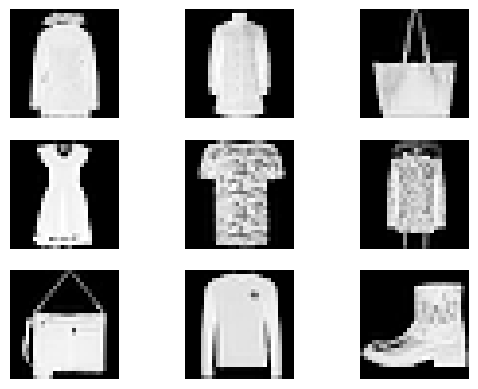

In [8]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [9]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [10]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoencoder convolucional* constituida por las siguientes capas:


1. Capa convolucional 2D (encoder) compuesta por:

  * Una capa `Conv2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) que mapea una entrada con $1$ canal y dimensiones $(28,28)$ a una salida con $16$ canales y dimensiones $(26,26)$.
    Utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
  * Una capa `ReLU`.
  * Una capa `MaxPool2d` con un kernel de dimensiones $(2,2)$, de modo que la salida resultante tenga dimensiones $(16,13,13)$.
  * Una capa `Dropout` con probabilidad $p$.

2. Capa lineal (cuello de botella o “bottleneck”) compuesta por:

  * Una capa `Flatten` que transforma una entrada de dimensiones $(16,13,13)$ en un vector de dimensión $16\times 13\times 13 = 2704$.
  * Una capa `Linear` que mapea el vector de dimensión $2704$ a un vector de dimensión $n$ (donde $n$ es un número mucho menor, por ejemplo $n=128$, representando la *codificación comprimida* o *latente*).
  * Una capa `ReLU`.
  * Una capa `Linear` que mapea de nuevo el vector de dimensión $n$ al espacio original de dimensión $2704$.
  * Una capa `ReLU`.

3. Capa convolucional 2D transpuesta (decoder) compuesta por:

  * Una capa `Unflatten` que mapea el vector de dimensión $2704$ a una representación de $16$ canales con dimensiones $(13,13)$.
  * Una capa `ConvTranspose2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Utilice un kernel de dimensiones $(6,6)$, un stride de $(2,2)$, y un padding de $(1,1)$.
  * Una capa `Sigmoid`, para asegurar que las salidas se encuentren en el rango $[0,1]$ (asumiendo que las imágenes originales también fueron normalizadas en dicho rango).

**2)** Grafique, a modo de comparación, algunas imágenes de entrada y sus correspondientes reconstrucciones obtenidas con el modelo **sin entrenar** y con una probabilidad de *dropout* $p=0.2$.

In [11]:
class AutoencoderExp1(nn.Module):
    """Experimento 1: Autoencoder convolucional básico"""

    def __init__(self, dropout = 0.2):
        super().__init__()
        # Encoder: (1, 28, 28) -> (32, 14, 14) -> (64, 7, 7)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Dropout(dropout),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 14, 14) -> (64, 7, 7)
        )

        # Decoder: (64, 7, 7) -> (32, 14, 14) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),  # (64, 7, 7) -> (32, 14, 14)
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),  # (32, 14, 14) -> (1, 28, 28)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

class AutoencoderExp2(nn.Module):
    """Experimento 2: Autoencoder con bottleneck lineal"""

    def __init__(self, latent_dim = 32, dropout = 0.2):
        super().__init__()
        # Encoder CNN: (1, 28, 28) -> (64, 7, 7)
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32, 28, 28) -> (64, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),  # (64, 28, 28) -> (64, 7, 7)
            nn.Dropout(dropout),
        )

        # Encoder fully connected: (64 * 7 * 7) -> 128 -> latent_dim
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),  # (64, 7, 7) -> 3136
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )

        # Decoder fully connected: latent_dim -> 128 -> (64 * 7 * 7)
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
        )

        # Decoder CNN: (64, 7, 7) -> (32, 14, 14) -> (1, 28, 28)
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),  # (64, 7, 7) -> (32, 14, 14)
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),  # (32, 14, 14) -> (1, 28, 28)
            nn.Sigmoid(),
        )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Codifica la imagen en un vector latente de dimensión latent_dim"""
        x = self.encoder_cnn(x)
        z = self.encoder_fc(x)
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Reconstruye la imagen a partir del vector latente z"""
        x = self.decoder_fc(z)
        x = x.view(-1, 64, 7, 7)
        x = self.decoder_cnn(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon


class AutoencoderExp3(nn.Module):
    """Experimento 3: Autoencoder convolucional más profundo"""

    def __init__(self, channel_scale = 1, dropout = 0.2):
        super().__init__()
        # Escalar canales para controlar el tamaño del modelo
        c1 = 32 * channel_scale
        c2 = 64 * channel_scale
        c3 = 64 * channel_scale

        # Encoder: (1, 28, 28) -> (c1, 14, 14) -> (c2, 7, 7)
        self.encoder = nn.Sequential(
            # Bloque 1: (1, 28, 28) -> (c1, 28, 28) -> (c1, 14, 14)
            nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(dropout),

            # Bloque 2: (c1, 14, 14) -> (c2, 14, 14) -> (c2, 7, 7)
            nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
        )

        # Decoder: (c2, 7, 7) -> (c1, 14, 14) -> (c3, 28, 28) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(c2, c1, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(c1, c3, kernel_size=2, stride=2),  # 14x14 -> 28x28
            nn.BatchNorm2d(c3),
            nn.ReLU(inplace=True),
            nn.Conv2d(c3, 1, kernel_size=3, stride=1, padding=1),  # (1, 28, 28)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [12]:
# 4.2)
# Creamos el modelo
p = 0.2
model = AutoencoderExp1()

In [13]:
# Create a dummy input tensor
image = torch.randn(1, 1, 28, 28) # batch size 1, channel 1, size 28x28
output = model(image)
print(f'Input size: (image.size())')
print(f'Output size: (output.size())')

Input size: (image.size())
Output size: (output.size())


In [14]:
def batch(x):
  return x.unsqueeze(0)   # (28,28) -> (1,28,28)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy() # (1,28,28) -> (28,28)

In [15]:
image,_ = train_set[0]
batched_image = batch(image)
print('batches_image.size()=',batched_image.size())
pred_batched_image = model(batched_image)
print('pred_batched_image.size()=',pred_batched_image.size())
pred_image = unbatch(pred_batched_image)
print('pred_image.shape=',pred_image.shape)

batches_image.size()= torch.Size([1, 1, 28, 28])
pred_batched_image.size()= torch.Size([1, 1, 28, 28])
pred_image.shape= (28, 28)


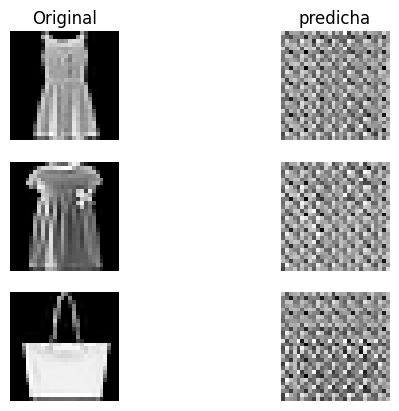

In [16]:
# Miramos que imagenes predice el modelo sin entrenar
figure = plt.figure()
rows,cols = 3,2
i = 0   #subplot index
for row in range(1, rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  # Ploteamos la imagen original
  i = i + 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('Original')
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")
  # Ploteamos la imagen predicha
  i = i + 1
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('predicha')
  plt.axis("off")
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap="Greys_r")
plt.show()

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [17]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer,verbose=True):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_samples = 0
    # Movemos el modelo a la GPU si es que está disponible
    model = model.to(device)
    #Iteramos sobre lotes (batchs)
    for batch, (X,y) in enumerate(dataloader):
        # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        # Calculamos la predicción del modelo y la correspondiente función de pérdida
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizaor provisto
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size
        # Reportamos el progreso
        if batch % (num_batches/10) == 0 and verbose:
            current = batch*len(X)
            avrg_loss = sum_loss/sum_samples
            print(f'@train_loop batch={batch:>5d} loss={avrg_loss:>7f} proccesed samples={100*sum_samples/num_samples:>5f}%')
    avrg_loss = sum_loss/num_samples
    return avrg_loss


In [18]:
# 5.2)
# De manera similar, definimos la función de validación
def eval_loop(dataloader,model,loss_fn):
  # Desactivamos la maquinaria e entrenamiento del modelo
  model.eval()
  # Definimos ciertas constantes
  num_samples = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss = 0
  sum_samples = 0
  # Movemos el modelo a la GPU si es que está disponible
  model = model.to(device)
  # Para testear, desactivmos el cálculo de gradientes
  with torch.no_grad():
    # Iteramos sobre lotes (batches)
    for X,y in dataloader:
      # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
      X = X.to(device)
      y = y.to(device)
      batch_size = len(X)     # number of samples in the batch
      sum_samples += batch_size
      # Calculamos las predicciones del modelo
      pred = model(X)
      loss = loss_fn(pred,y)
      # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
      sum_loss += loss.item() * batch_size
  # Calculamos la pérdida total y la fracción de clasificaciones correctas y las imprimimos
  avrg_loss = sum_loss/sum_samples
  #print(f'@eval loop avrg loss={avg loss:>8f}')
  return avrg_loss


In [19]:
# 5.3)
# Creamos los data loaders
batch_size = 100
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=600
num_valid_batches=100


In [20]:
# 5.4)
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
#loss_fun = = nn.CrossEntropyLoss() # Para clasificación
loss_fn = nn.MSELoss() # Para autoencoder

In [21]:
# 5.5)
# Creamos el modelo
p = 0.2
model = AutoencoderExp1()

In [22]:
# 5.6)
# Creamos un optimizador, un Stochastic Gradient Descent o un ADAM
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameter(),lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [23]:
# 5.7)
# Determinamos en que dispositivo vamos a trabajar, con una CPU o GPU
devide = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)

In [24]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas
# Además, testeamos el modelo en cada una de ellas
num_epochs = 50
list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []
for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}\n-------------------------------')
  avg_train_loss_incorrecta = train_loop(train_loader,model,loss_fn,optimizer)
  avg_train_loss = eval_loop(train_loader,model,loss_fn)
  avg_valid_loss = eval_loop(valid_loader,model,loss_fn)
  list_avg_train_loss_incorrecta.append(avg_train_loss_incorrecta)
  list_avg_train_loss.append(avg_train_loss)
  list_avg_valid_loss.append(avg_valid_loss)
  print('avg_train_loss_incorrecta.append=',avg_train_loss_incorrecta)
  print('avg_train_loss.append=',avg_train_loss)
  print('avg_valid_loss.append=',avg_valid_loss)
print('Done!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=1.597969 proccesed samples=0.166667%
@train_loop batch=   60 loss=0.835712 proccesed samples=10.166667%
@train_loop batch=  120 loss=0.735647 proccesed samples=20.166667%
@train_loop batch=  180 loss=0.698189 proccesed samples=30.166667%
@train_loop batch=  240 loss=0.675922 proccesed samples=40.166667%
@train_loop batch=  300 loss=0.660770 proccesed samples=50.166667%
@train_loop batch=  360 loss=0.649904 proccesed samples=60.166667%
@train_loop batch=  420 loss=0.641515 proccesed samples=70.166667%
@train_loop batch=  480 loss=0.635127 proccesed samples=80.166667%


KeyboardInterrupt: 

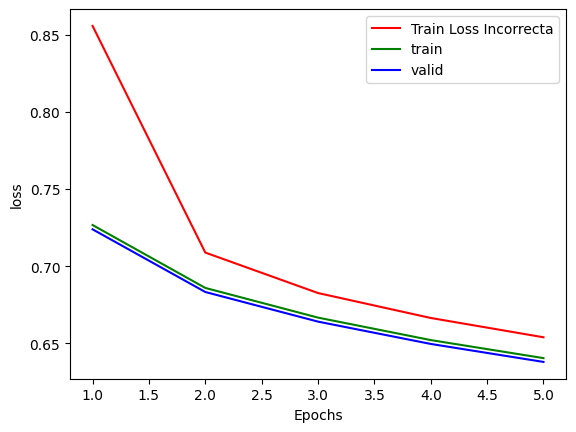

In [ ]:
# 5.10)
plt.xlabel('Epochs')
plt.ylabel('loss')
# plt.xlim(-0.1,5.1)
# plt.ylim(-0.1,1.1)
plt.plot(list(range(1,len(list_avg_train_loss_incorrecta)+1)),list_avg_train_loss_incorrecta,label='Train Loss Incorrecta',linestyle='-',c='red')
plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss,label='train',linestyle='-',c='green')
plt.plot(list(range(1,len(list_avg_valid_loss)+1)),list_avg_valid_loss,label='valid',linestyle='-',c='blue')
plt.title('')
plt.legend()

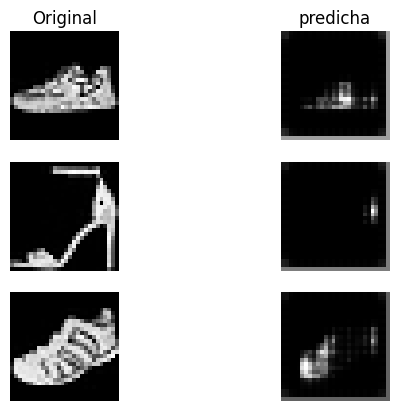

In [ ]:
# Miramos que imagenes predice el modelo entrenado
# Revisar
# 5.11)
figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
model.eval()
for row in range(1, rows+1):
  j = torch.randint(len(train_set),size=(1,)).item() # Los numeros aleatorios tambien se pueden generar desde pytorch. Util para trabajar en a GPU
  # Ploteamos la imagen original
  i = i + 1
  image,flatten_imagen = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('Original')
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")
  # Ploteamos la imagen predicha
  i = i + 1
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('predicha')
  plt.axis("off")
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap="Greys_r")
plt.show()

